# Video Games Review: Analysis

In this project, I explore [Metacritic's video games reviews](https://www.metacritic.com/browse/games/score/metascore/all/all/filtered?page=0).


## Setup

In this section, I import all necessary libraries, setup the SQLite database, and then import the input `.csv` files in a format that allows manipulation by both `sqlite` and `pandas`:


In [133]:
import os
import pandas as pd
from sqlalchemy import create_engine

# creating SQLite database
engine = create_engine("sqlite://", echo=False)

In [134]:
from glob import glob

csv_paths = glob("./input/*.csv")

dfs = {}
for c in csv_paths:
    c_cleaned = c.split("\\", maxsplit=2)[-1].split(".")[0]
    dfs[c_cleaned] = pd.read_csv(c).sort_values(["name", "platform"])
    dfs[c_cleaned].to_sql(c_cleaned, engine, if_exists="replace", index=False)
    display(c_cleaned, dfs[c_cleaned].head(3))


'meta'

,meta_score,meta_rank,name,platform,release_date,summary
12510,69,12511.0,#DRIVE,Platform: Switch,"February 16, 2021",#DRIVE is an endless driving videogame inspire...
6686,77,6687.0,#IDARB,Platform: Xbox One,"January 30, 2015",#IDARB started as a picture of red box. Then m...
18217,53,18218.0,#KILLALLZOMBIES,Platform: Xbox One,"August 10, 2016",In the distant future; #KILLALLZOMBIES is thru...


'user'

,user_score,user_rank,name,platform,release_date,summary
11700,6.8,11701.0,#DRIVE,Platform: Switch,"February 16, 2021",#DRIVE is an endless driving videogame inspire...
11388,6.9,11389.0,#IDARB,Platform: Xbox One,"January 30, 2015",#IDARB started as a picture of red box. Then m...
6321,7.7,6322.0,'Splosion Man,Platform: Xbox 360,"July 22, 2009","[Xbox Live Arcade] Fools they were, to tread w..."


## Cleaning

### Joining two tables

In [135]:
# merging
merged_df = pd.read_sql_query(
    """
    SELECT m.meta_score, 
        u.user_score,
        u.name,
        u.platform,
        u.release_date,
        u.summary
    FROM user u
    LEFT JOIN meta m
        USING (name, platform, release_date) 
    UNION
    SELECT m.meta_score,
        u.user_score,
        m.name,
        m.platform,
        m.release_date,
        m.summary
    FROM meta m
    LEFT JOIN user u
        USING (name, platform, release_date)
    ORDER BY name, platform
    """,
    engine,
)

merged_df.head()


,meta_score,user_score,name,platform,release_date,summary
0,69,6.8,#DRIVE,Platform: Switch,"February 16, 2021",#DRIVE is an endless driving videogame inspire...
1,77,6.9,#IDARB,Platform: Xbox One,"January 30, 2015",#IDARB started as a picture of red box. Then m...
2,53,NaN,#KILLALLZOMBIES,Platform: Xbox One,"August 10, 2016",In the distant future; #KILLALLZOMBIES is thru...
3,84,7.7,'Splosion Man,Platform: Xbox 360,"July 22, 2009","[Xbox Live Arcade] Fools they were, to tread w..."
4,46,3.7,.detuned,Platform: PlayStation 3,"October 15, 2009",[Playstation Network] Developed by .theprodukk...


### Ensuring Datetime data type

As SQLite does not support month names ([StackOverflow](https://stackoverflow.com/questions/1181123/date-formatting-from-sqlite-query)) as is found in the `release_date` column, we use [`pandas.to_datetime()`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) method instead:


In [136]:
# convert "release_date" column to datetime format
merged_df["release_date"] = pd.to_datetime(merged_df.release_date, format="%B %d, %Y")
merged_df.head()

,meta_score,user_score,name,platform,release_date,summary
0,69,6.8,#DRIVE,Platform: Switch,2021-02-16,#DRIVE is an endless driving videogame inspire...
1,77,6.9,#IDARB,Platform: Xbox One,2015-01-30,#IDARB started as a picture of red box. Then m...
2,53,NaN,#KILLALLZOMBIES,Platform: Xbox One,2016-08-10,In the distant future; #KILLALLZOMBIES is thru...
3,84,7.7,'Splosion Man,Platform: Xbox 360,2009-07-22,"[Xbox Live Arcade] Fools they were, to tread w..."
4,46,3.7,.detuned,Platform: PlayStation 3,2009-10-15,[Playstation Network] Developed by .theprodukk...


### Removing string prefix in `platform` column

As all values in the `platform` column has a `"Platform: "` prefix, I use SQL's `SUBSTR()` to begin the string at a later index.

If the the unwanted substring is not consistently a prefix, I would use `REPLACE()` instead.


In [137]:
# displaying distinct values of `platform` column to confirm all values start with prefix
merged_df.to_sql("games", engine, if_exists="replace", index=False)
pd.read_sql_query("SELECT DISTINCT platform FROM games", engine)


,platform
0,Platform: Switch
1,Platform: Xbox One
2,Platform: Xbox 360
3,Platform: PlayStation 3
4,Platform: PC
5,Platform: PlayStation 4
6,Platform: PlayStation 2
7,Platform: PlayStation
8,Platform: DS
9,Platform: Wii


In [138]:
merged_df = pd.read_sql_query(
    """
    SELECT name,
        SUBSTR(platform, 11) platform,
        release_date,
        summary,
        meta_score,
        user_score
    FROM 
        games
        """,
    engine,
)
merged_df.head()


,name,platform,release_date,summary,meta_score,user_score
0,#DRIVE,Switch,2021-02-16 00:00:00.000000,#DRIVE is an endless driving videogame inspire...,69,6.8
1,#IDARB,Xbox One,2015-01-30 00:00:00.000000,#IDARB started as a picture of red box. Then m...,77,6.9
2,#KILLALLZOMBIES,Xbox One,2016-08-10 00:00:00.000000,In the distant future; #KILLALLZOMBIES is thru...,53,NaN
3,'Splosion Man,Xbox 360,2009-07-22 00:00:00.000000,"[Xbox Live Arcade] Fools they were, to tread w...",84,7.7
4,.detuned,PlayStation 3,2009-10-15 00:00:00.000000,[Playstation Network] Developed by .theprodukk...,46,3.7


### Missing Values

Though there are missing values in the dataset, there is NFA to impute as:

1. The `meta_score` and `user_score` columns are missing if there are <4 and <7 reviews for that game respectively, and is not possible to impute.
2. The `summary` of the game is authored by Metacritic, which is also difficult to impute.


In [139]:
pd.read_sql_query(
    """
    SELECT SUM(CASE WHEN meta_score IS NULL THEN 1 ELSE 0 END) meta_score_miss,
        SUM(CASE WHEN user_score IS NULL THEN 1 ELSE 0 END) user_score_miss,
        SUM(CASE WHEN name IS NULL THEN 1 ELSE 0 END) name_miss,
        SUM(CASE WHEN platform IS NULL THEN 1 ELSE 0 END) platform_miss,
        SUM(CASE WHEN release_date IS NULL THEN 1 ELSE 0 END) release_date_miss,
        SUM(CASE WHEN summary IS NULL THEN 1 ELSE 0 END) summary_miss
    FROM games
    """,
    engine,
)


,meta_score_miss,user_score_miss,name_miss,platform_miss,release_date_miss,summary_miss
0,0,1401,0,0,0,94


### Duplicates


In [140]:
# deduplicate first as no entries should be identical for all columns
merged_df = merged_df.drop_duplicates()
merged_df.to_sql("games", engine, if_exists="replace", index=False)

# check duplicates for "name", "summary" columns, as the other attributes can be expected to have duplicates
# exclude null values using `WHERE` statement as these will duplicate
for col in ["name", "summary"]:
    dup_df = pd.read_sql_query(
        f"""
        SELECT {col}, COUNT(*) counts
        FROM games
        WHERE {col} NOT NULL
        GROUP BY 1
        HAVING counts > 1
        ORDER BY 2 DESC
        """,
        engine,
    )
    if not dup_df.empty:
        display(col, dup_df)


'name'

,name,counts
0,Madden NFL 07,9
1,Madden NFL 06,8
2,X-Men: The Official Game,7
3,Tiger Woods PGA Tour 07,7
4,The Sims 2,7
...,...,...
4134,1942: Joint Strike,2
4135,187 Ride or Die,2
4136,13 Sentinels: Aegis Rim,2
4137,10 Second Ninja X,2


'summary'

,summary,counts
0,The game involves players creating and destroy...,7
1,Need for Speed ProStreet accelerates street ra...,7
2,LEGO Indiana Jones: The Original Adventures ta...,7
3,"Iron Man, an explosive third-person action sho...",7
4,"In Harry Potter and the Order of the Phoenix, ...",7
...,...,...
2992,'DARK SOULS II Crown of the Ivory King' is the...,2
2993,"""Street Fighter"" is best known for its well-po...",2
2994,"""Our goal was to create a game that is perfect...",2
2995,"""Only the possibility of you can change our fa...",2


The `name` column has duplicates largely due to each row representing a game for a particular _platform_. Eg: if a game was released on PC, PS4 and PS5 -- each of these will have its own entry.

However, if there are games that also duplicate when the `name` and `platform` columns are grouped, the entry that has incorrect attributes should be removed.

In [141]:
pd.read_sql_query(
    """
    SELECT name,
        platform,
        COUNT(*) counts
    FROM games
    GROUP BY 1, 2
    HAVING counts > 1
    ORDER BY 3 DESC
    """,
    engine,
)


,name,platform,counts


In [142]:
# find entries for above games (and their platform) which duplicates
# create "name_platform" helper column to identify unique name+platform pairs
dups_df = pd.read_sql_query(
    """
    WITH dups_name_platform AS (
        SELECT name, 
            platform,
            COUNT(*) counts
        FROM games
        GROUP BY 1, 2
        HAVING counts > 1
    )
    
    SELECT g.*,
        REPLACE(LOWER(name), ' ', '-') || '//' || REPLACE(LOWER(platform), ' ', '-') name_platform
    FROM games g
    JOIN dups_name_platform
    USING (name, platform)
    """,
    engine,
)

dups_df


,name,platform,release_date,summary,meta_score,user_score,name_platform


In [143]:
# confirm on site the actual score of the duplicated entry
from scraper import setup_chrome_driver
from selenium.webdriver.common.by import By

if not dups_df.empty:
    DRIVER = setup_chrome_driver()
    for n in set(dups_df.name_platform):
        name_platform_split = n.split("//")
        game_name_cleaned = name_platform_split[0]
        platform_name_cleaned = name_platform_split[1]

        game_url = f"https://www.metacritic.com/game/{platform_name_cleaned}/{game_name_cleaned}"

        DRIVER.get(game_url)
        metascore_indiv = float(
            DRIVER.find_element(
                By.XPATH,
                '//*[@id="main"]/div/div[1]/div[1]/div[3]/div/div[2]/div[1]/div[1]/div/div/a/div',
            ).text
        )
        userscore_indiv = float(
            DRIVER.find_element(
                By.XPATH,
                '//*[@id="main"]/div/div[1]/div[1]/div[3]/div/div[2]/div[1]/div[2]/div[1]/div/a/div',
            ).text
        )

        # check that a row with those values exist
        check_entry_df = dups_df[
            (dups_df.name_platform == n)
            & (dups_df.meta_score == float(metascore_indiv))
            & (dups_df.user_score == float(userscore_indiv))
        ]
        if check_entry_df.empty:
            raise Exception(
                f"""The game "{check_entry_df.name.values[0]}" on "{check_entry_df.platform.values[0]}" has incorrect Metascore and/or User Score. Please re-run scraper.py or manually update the CSV(s)."""
            )

        # replace scores with correct ones and dedup
        game_name = check_entry_df.name.values[0]
        platform_name = check_entry_df.platform.values[0]

        merged_df.loc[
            (merged_df.name == game_name) & (merged_df.platform == platform_name),
            ["meta_score"],
        ] = metascore_indiv
        merged_df.loc[
            (merged_df.name == game_name) & (merged_df.platform == platform_name),
            ["user_score"],
        ] = userscore_indiv

        merged_df.drop_duplicates(inplace=True)

        display(merged_df[merged_df.name == check_entry_df.name.values[0]])
    DRIVER.close()


Similarly, `summary` column duplicates due to each row referring to a game that, despite being released on different platforms, have the same game summary.

In [144]:
merged_df.to_sql("games", engine, if_exists="replace", index=False)

pd.read_sql_query(
    """
    SELECT name,
        platform,
        summary,
        COUNT(*) counts
    FROM games
    WHERE summary NOT NULL
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    """,
    engine,
)


,name,platform,summary,counts
0,#DRIVE,Switch,#DRIVE is an endless driving videogame inspire...,1
1,#IDARB,Xbox One,#IDARB started as a picture of red box. Then m...,1
2,#KILLALLZOMBIES,Xbox One,In the distant future; #KILLALLZOMBIES is thru...,1
3,'Splosion Man,Xbox 360,"[Xbox Live Arcade] Fools they were, to tread w...",1
4,.detuned,PlayStation 3,[Playstation Network] Developed by .theprodukk...,1
...,...,...,...,...
19893,rain,PlayStation 3,"Developed by PlayStation C.A.M.P!, the creativ...",1
19894,theHunter: Call of the Wild,PC,Experience the thrill of the hunt in a vast op...,1
19895,uDraw Studio,Wii,"Packaged with the uDraw GameTablet, uDraw Stud...",1
19896,void tRrLM(); //Void Terrarium,Switch,"In a world contaminated with toxic fungi, a di...",1


## Analysis

### Metascore vs User Scores
There are up to two scores (assuming sufficient rating volumes) for each game: 
* A game's **Metascore** is the [weighted average of critics' and publications' reviews](https://www.metacritic.com/about-metascores).
* A game's **user score** is the mean of users' scores. However, this score has been criticised online as users can provide reviews despite not owning the game (*[Reddit](https://www.reddit.com/r/NintendoSwitch/comments/rjn72b/metacritic_criticuser_reviews_do_they_mean/)*).

#### Metascores and user scores have a ***low***, ***positive*** correlation
The Pearson Correlation Coefficient is approx `+0.270`.

Unlike other SQL implementations (like PostgreSQL's `CORR()`), SQLite lacks built-in function to calculate the correlation coefficient. Thus, I implement the calculation manually using the formula:

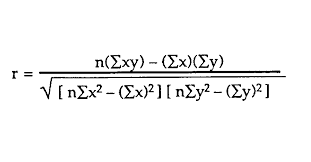

In [145]:
pd.read_sql_query(
    """
    SELECT AVG( (user_score - avg_userscore) * (meta_score - avg_metascore) ) * AVG( (user_score - avg_userscore) * (meta_score - avg_metascore) ) / (var_userscore * var_metascore) AS pearson_corr_coeff 
    FROM games,
        (
            SELECT avg_userscore,
                avg_metascore,
                AVG((user_score - avg_userscore)*(user_score - avg_userscore)) as var_userscore,
                AVG((meta_score - avg_metascore)*(meta_score - avg_metascore)) as var_metascore
            FROM games,
                (
                    SELECT AVG(user_score) AS avg_userscore,
                        AVG(meta_score) AS avg_metascore
                    FROM games
                )
        )
    """,
    engine,
)


,pearson_corr_coeff
0,0.270227


Visually, a scatterplot of all games' user score (x-axis) against Metascore (y-axis) validates this positive correlation.

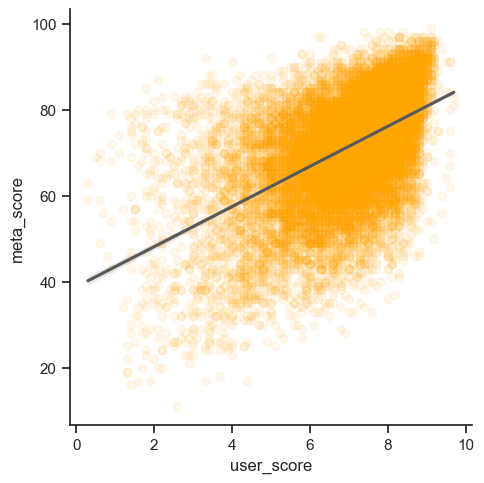

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.lmplot(
    data=merged_df,
    x="user_score",
    y="meta_score",
    scatter_kws={"color": "orange", "alpha": 0.08},
    line_kws={"color": "#595959"},
)
plt.show()


### Platforms

#### **Nintendo 64** and **PlayStation** have the highest rated games

In [147]:
# transforming table to allow split boxplots
# normalise meta_score by having it out of 10 instead of 100

scores_stacked_df = pd.read_sql_query(
    """
    SELECT name,
        platform,
        meta_score / 10 score, 
        'meta' score_type
    FROM games
    WHERE score NOT NULL
    UNION ALL
    SELECT name,
        platform,
        user_score score,
        'user' score_type
    FROM games
    WHERE score NOT NULL
    ORDER BY platform
""",
    engine,
)
scores_stacked_df.head(3)


,name,platform,score,score_type
0,3D After Burner II,3DS,8.0,meta
1,3D Classics: Kid Icarus,3DS,7.0,meta
2,3D Classics: Kirby's Adventure,3DS,7.0,meta


As SQLite does not have a built-in function nor efficient alternative to query the median values of each platform, we use `pandas`' `.median()` method:

In [173]:
median_scores_df = (
    scores_stacked_df.groupby(["platform", "score_type"])
    .score.median()
    .reset_index()
    .rename(columns={"score": "median_score"})
)
median_scores_df


,platform,score_type,median_score
0,3DS,meta,7.00
1,3DS,user,7.40
2,DS,meta,6.00
3,DS,user,7.50
4,Dreamcast,meta,7.00
5,Dreamcast,user,8.00
6,Game Boy Advance,meta,7.00
7,Game Boy Advance,user,7.90
8,GameCube,meta,7.00
9,GameCube,user,7.80


With the exception of Nintendo DS and Nintendo Wii, Metascores' distribution for each platform is similar to one another. 

**Nintendo DS** and **Nintendo Wii** have lower, median and interquartile range of *Metascores*, though *users* have reviewed games of other platforms lower. 

Overall, the higher number of outliers for *user* scores (as compared to Metascores) imply users tend to disagree with one another more than critics, which is expected. In particular, **PC** games have noticeably more low-end outliers, especially for user scores <4.

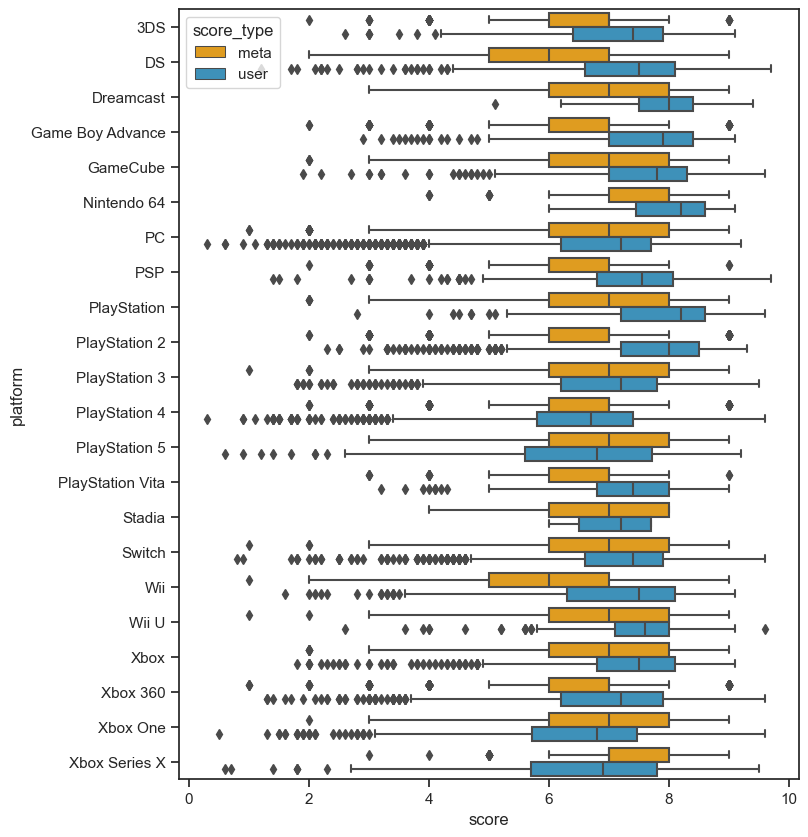

In [170]:
plt.figure(figsize=(8, 10))
bp = sns.boxplot(
    data=scores_stacked_df,
    x="score",
    y="platform",
    hue="score_type",
    orient="h",
    palette=["orange", "#2998cd"],
)
plt.show()


#### Where games are released on multiple platforms...

In [150]:
# where games are released on multiple platforms, do certain platforms of the _same game_ outperform its release on another?

In [151]:
# also scrape ios games?